In [14]:
%load_ext autoreload
%autoreload 2

In [17]:
import pandas as pd
import numpy as np
import argparse
import random
from model import KGCN
from data_loader import DataLoader
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [18]:
parser = argparse.ArgumentParser()

parser.add_argument('--dataset', type=str, default='music', help='which dataset to use')
parser.add_argument('--aggregator', type=str, default='sum', help='which aggregator to use')
parser.add_argument('--n_epochs', type=int, default=10, help='the number of epochs')
parser.add_argument('--neighbor_sample_size', type=int, default=8, help='the number of neighbors to be sampled')
parser.add_argument('--dim', type=int, default=16, help='dimension of user and entity embeddings')
parser.add_argument('--n_iter', type=int, default=1, help='number of iterations when computing entity representation')
parser.add_argument('--batch_size', type=int, default=128, help='batch size')
parser.add_argument('--l2_weight', type=float, default=1e-4, help='weight of l2 regularization')
parser.add_argument('--lr', type=float, default=5e-4, help='learning rate')
parser.add_argument('--ratio', type=float, default=0.8, help='size of training dataset')

args = parser.parse_args(['--l2_weight', '1e-4'])

In [19]:
data_loader = DataLoader(args.dataset)
kg = data_loader.load_kg()
df_dataset = data_loader.load_data()
#df_dataset = df_dataset.sample(frac=0.5, replace=False)
df_dataset.head()

Construct knowledge graph ... Done
Build dataset dataframe ... Done


,index,userID,itemID,label
0,13212,1165,632,1
1,11081,979,705,1
2,7146,634,1886,1
3,6575,585,1344,0
4,8622,767,3063,0


In [20]:
class KGCNDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        user_id = np.array(self.df.iloc[idx]['userID'])
        movie_id = np.array(self.df.iloc[idx]['itemID'])
        label = np.array(self.df.iloc[idx]['label'], dtype=np.float32)
        return user_id, movie_id, label

In [21]:
x_train, x_test, y_train, y_test = train_test_split(df_dataset, df_dataset['label'], test_size=1 - args.ratio)
train_dataset = KGCNDataset(x_train)
test_dataset = KGCNDataset(x_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size)

In [28]:
from model import KGCN
num_user, num_entity, num_relation = data_loader.get_num()
user_encoder, entity_encoder, relation_encoder = data_loader.get_encoders()
net = KGCN(num_user, num_entity, num_relation, kg, args)
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2_weight)

In [29]:
user_id, movie_id, label = iter(train_loader).next()
outputs = net(user_id, movie_id)

user_embeddings shape:  torch.Size([128, 16])


RuntimeError: index out of range: Tried to access index 4150 out of table with 59 rows. at /opt/conda/conda-bld/pytorch_1579040055865/work/aten/src/TH/generic/THTensorEvenMoreMath.cpp:418

In [8]:
pn = 50
loss_list = []
test_loss_list = []
auc_score_list = []
for epoch in range(args.n_epochs):
    running_loss = 0.0
    for i, (user_id, movie_id, label) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = net(user_id, movie_id)
        loss = criterion(outputs, label)
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()
        if i % pn == pn-1:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch+1, i + 1, running_loss / pn))
            loss_list.append(running_loss / pn)
            running_loss = 0.0
            
            with torch.no_grad():
                test_loss = 0
                total_roc = 0
                for (uid, mid, l) in test_loader:
                    out = net(uid, mid)
                    test_loss += criterion(out, l).item()
                    total_roc += roc_auc_score(l.detach().numpy(), out.detach().numpy())
                print('test_loss: ', test_loss / pn)
                test_loss_list.append(test_loss / pn)
                auc_score_list.append(total_roc / pn)

[1,    50] loss: 1.165
test_loss:  1.4700547182559967
[1,   100] loss: 1.107
test_loss:  1.3978251135349273
[1,   150] loss: 1.024
test_loss:  1.3337354815006257
[1,   200] loss: 1.009
test_loss:  1.275613089799881
[1,   250] loss: 0.934
test_loss:  1.2271353828907012
[2,    50] loss: 0.898
test_loss:  1.1711366939544678
[2,   100] loss: 0.865
test_loss:  1.1345440196990966
[2,   150] loss: 0.820
test_loss:  1.1054645240306855
[2,   200] loss: 0.820
test_loss:  1.0781964337825776
[2,   250] loss: 0.783
test_loss:  1.0566569948196411
[3,    50] loss: 0.771
test_loss:  1.031594603061676
[3,   100] loss: 0.755
test_loss:  1.0155018055438996
[3,   150] loss: 0.736
test_loss:  1.003670471906662
[3,   200] loss: 0.738
test_loss:  0.9919656193256379
[3,   250] loss: 0.722
test_loss:  0.9832029366493225
[4,    50] loss: 0.720
test_loss:  0.9727196276187897
[4,   100] loss: 0.712
test_loss:  0.9664079773426056
[4,   150] loss: 0.705
test_loss:  0.9622074055671692
[4,   200] loss: 0.706
test_los

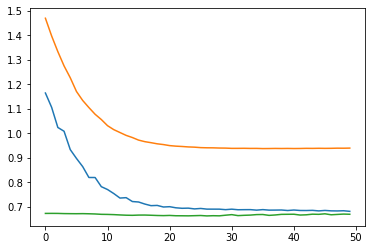

In [9]:
plt.plot(loss_list)
plt.plot(test_loss_list)
plt.plot(auc_score_list)
plt.show()